In [1]:
# all internal libraries
import pathlib
import time
import datetime
import io
import urllib
import tempfile

# dependencies
import shapely.geometry
import networkx as nx
import simpy
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# our software
import opentnsim.core

%matplotlib inline

In [2]:
# link to the latets version of the network
url = 'https://zenodo.org/record/3981105/files/network_digital_twin_v0.1.yaml'


In [3]:
# Reading network (might take a few minutes on a slow connection)

# Create a temporary file
f = tempfile.NamedTemporaryFile()
f.close()

urllib.request.urlretrieve(url, f.name)
G = nx.read_yaml(f.name)

# Making geometry really a geometry type
for n in G.nodes:
    G.nodes[n]['geometry'] = shapely.geometry.Point(G.nodes[n]['X'], G.nodes[n]['Y'])
    
del f

## Repeat for real case

In [4]:
# Creating a library of some interesting locations
def find_closest_node(G, point):
    """ Find the node on graph G that is closest to the given 
    shapely.geometry.Point point """
    distance = np.full((len(G.nodes)), fill_value=np.nan)
    for ii, n in enumerate(G.nodes):
        distance[ii] = point.distance(G.nodes[n]['geometry'])
    name_node = list(G.nodes)[np.argmin(distance)]
    distance_node = np.min(distance)
    return name_node, distance_node

# some interesting locations
locations = {
    'Transferium Maasvlakte': shapely.geometry.Point(4.087406, 51.936737),
    'Neusse': shapely.geometry.Point(6.708892, 51.215737),
    'Basel': shapely.geometry.Point(7.640572, 47.555449),
    'Nijmegen': shapely.geometry.Point(5.8161152, 51.8570535),
    'Waal at St. Andries': shapely.geometry.Point(5.350339, 51.803965)
}

# find the closest nodes on the graph
locations_nodes = {n: find_closest_node(G, locations[n])[0] for n in locations}


In [5]:
# define environment
env = simpy.Environment()

# set time for simulation
simulation_start = datetime.datetime(2018, 7, 1)
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())

# Add graph to environment
env.FG = G.copy()

In [6]:
# Find basic route
start_point = locations_nodes['Transferium Maasvlakte']
end_point = locations_nodes['Nijmegen']
path = nx.dijkstra_path(env.FG, start_point, end_point, weight='Length')

# blockin at...
blocking = locations_nodes['Waal at St. Andries']

# assert that the blocking is in the route
print(f'The blocking is in the path: {blocking in path}')
assert blocking in path, 'Blocking should be in the shortest path'

# quick check on the graph: do the edges have resources?
edge = list(env.FG.edges(blocking))[0]
print(f'Edges have resources? {"Resources" in env.FG.edges[edge].keys()}')

The blocking is in the path: True
Edges have resources? False


In [7]:
# get all edges connecting to St. Andries
blocked_edges = []
for edge in env.FG.edges():
    if blocking in edge:
        blocked_edges.append(edge)

# set a trigger (node) for the edge to be blocked 2/4 of the way towards the blocked node
index = int(path.index(blocking)*(2/4))
trigger_node = path[index]

In [8]:
# Make a transport resource class out of mix-ins
TransportResource = type('TransportResource', 
                         (opentnsim.core.Identifiable, opentnsim.core.ContainerDependentMovable, 
                          opentnsim.core.HasResource, opentnsim.core.Routeable), {})

# For testing purposes we only want v to be 1, whether empty or loaded
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

# Define vessel data, but do not yet link to env or route
data_vessel = {"env": None,
               "name": "Vessel number 1",
               "route": None,
               "geometry": G.nodes[start_point]['geometry'],  # lon, lat
               "capacity": 1_000,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}


In [9]:
# create the transport processing resource
vessel1 = TransportResource(**data_vessel)

# Add the vessel to the environment, and define the start and end point
vessel1.env = env
vessel1.start_loc = start_point
vessel1.end_loc = end_point

# also define its current location as the start point for now
vessel1.current_loc = start_point

# add the route
vessel1.route = path

# check route
#vessel1.route

In [10]:
# create the transport processing resource
vessel2 = TransportResource(**data_vessel)

# Add the vessel to the environment, and define the start and end point
vessel2.env = env
vessel2.start_loc = start_point
vessel2.end_loc = end_point

# also define its current location as the start point for now
vessel2.current_loc = start_point

#--> seems as though this path is sailed even though it is updated on the while loop of the start function

# add the route (is it needed to add it as an empty list?)
#vessel2.route = []

# check route
#vessel2.route

In [11]:
# simply move a vessel accross a predefined route
def start(env, vessel):
    yield from vessel.move()
    

In [12]:
# function to sail vessel with route decision
def start_dynamic(env, vessel, blocked_edges, trigger_node):
    """ Have a vessel sail from start_point to end_point, while after every
    egde passed checking if the current route is still available"""
    # while vessel's current location is not end location
    while vessel.current_loc != vessel.end_loc:
        # activate blockage if triggered
        if vessel.current_loc == trigger_node:
            for blocked_edge in blocked_edges:
                env.FG.edges[blocked_edge]['Length'] = 999999
        # determine the shortest path from the current to the end location given the current conditions
        shortest_path = nx.dijkstra_path(env.FG, vessel.current_loc, vessel.end_loc, weight='Length')
        # make sure the vessel passes only the first edge in the route
        vessel.route = [shortest_path[0], shortest_path[1]]
        # make sure the current location is now updated
        vessel.current_loc = shortest_path[1]
        yield from vessel.move()
    

In [13]:
# add the processes and run the environments
env.process(start(env, vessel1))
env.process(start_dynamic(env, vessel2, blocked_edges, trigger_node))
env.run()

In [14]:
# check the log of vessel 1
df1 = pd.DataFrame.from_dict(vessel1.log)
df1.head(4).append(df1.tail(4))

,Message,Timestamp,Value,Geometry
0,Sailing from node 22161408.0 to node 22161426....,2018-07-01 00:00:00.000000,0,POINT (4.08441957198572 51.9376698026918)
1,Sailing from node 22161408.0 to node 22161426....,2018-07-01 00:03:48.775496,0,POINT (4.08575840028067 51.9395520396609)
2,Sailing from node 22161426.0 to node 8863826.0...,2018-07-01 00:03:48.775496,0,POINT (4.08575840028067 51.9395520396609)
3,Sailing from node 22161426.0 to node 8863826.0...,2018-07-01 00:05:40.134353,0,POINT (4.08419044915029 51.9398020492115)
234,Sailing from node 8864190.0 to node L49032_B s...,2018-07-02 15:33:13.740234,0,POINT (5.82339965181606 51.8543638231455)
235,Sailing from node 8864190.0 to node L49032_B stop,2018-07-02 15:35:20.274571,0,POINT (5.822588443819979 51.85334354929841)
236,Sailing from node L49032_B to node L49032_A start,2018-07-02 15:35:20.274571,0,POINT (5.822588443819979 51.85334354929841)
237,Sailing from node L49032_B to node L49032_A stop,2018-07-02 15:35:59.104869,0,POINT (5.822339504594138 51.85303045304829)


In [15]:
# check the log of vessel 2
df2 = pd.DataFrame.from_dict(vessel2.log)
df2.head(4).append(df2.tail(4))

,Message,Timestamp,Value,Geometry
0,Sailing from node 22161408.0 to node 22161426....,2018-07-01 00:00:00.000000,0,POINT (4.08441957198572 51.9376698026918)
1,Sailing from node 22161408.0 to node 22161426....,2018-07-01 00:03:48.775496,0,POINT (4.08575840028067 51.9395520396609)
2,Sailing from node 22161426.0 to node 8863826.0...,2018-07-01 00:03:48.775496,0,POINT (4.08575840028067 51.9395520396609)
3,Sailing from node 22161426.0 to node 8863826.0...,2018-07-01 00:05:40.134353,0,POINT (4.08419044915029 51.9398020492115)
238,Sailing from node 8864190.0 to node L49032_B s...,2018-07-02 14:52:14.382366,0,POINT (5.82339965181606 51.8543638231455)
239,Sailing from node 8864190.0 to node L49032_B stop,2018-07-02 14:54:20.916704,0,POINT (5.822588443819979 51.85334354929841)
240,Sailing from node L49032_B to node L49032_A start,2018-07-02 14:54:20.916704,0,POINT (5.822588443819979 51.85334354929841)
241,Sailing from node L49032_B to node L49032_A stop,2018-07-02 14:54:59.747001,0,POINT (5.822339504594138 51.85303045304829)


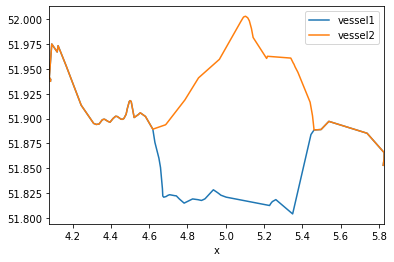

In [16]:
# create figure
fix, ax = plt.subplots()

# get log and plot track of vessel 1
df1['x'] = df1.Geometry.apply(lambda geom: geom.x)
df1['y'] = df1.Geometry.apply(lambda geom: geom.y)
df1.plot('x', 'y', label='vessel1', ax=ax)

# get log and plot track of vessel 2
df2['x'] = df2.Geometry.apply(lambda geom: geom.x)
df2['y'] = df2.Geometry.apply(lambda geom: geom.y)
df2.plot('x', 'y', label='vessel2', ax=ax)

In [17]:
gdf1 = gpd.GeoDataFrame(df1.rename(columns={'Geometry':'geometry'}), crs="EPSG:4326")
gdf2 = gpd.GeoDataFrame(df2.rename(columns={'Geometry':'geometry'}), crs="EPSG:4326")

In [18]:
import folium
import shapely
m = folium.Map(location=[52, 5], zoom_start=9)
col1 = '#ff0000'
col2 = '#3785b8'

style1 = {'fillColor': col1, 'color': col1, 'line_opacity': 0.5}
style2 = {'fillColor': col2, 'color': col2, 'opacity': 0.8}

folium.GeoJson(shapely.geometry.LineString(gdf1.geometry), style_function=lambda x:style1).add_to(m)
folium.GeoJson(shapely.geometry.LineString(gdf2.geometry), style_function=lambda x:style2).add_to(m)

folium.Marker([G.nodes[blocking]['Y'],G.nodes[blocking]['X']],
          icon = folium.Icon(icon='times', color='red', prefix='fa'),
          ).add_to(m)

m